**RAN ON GOOGLE COLAB**

In [2]:
!pip install ml-collections

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.4 MB/s eta 0:00:00


In [31]:
# ====== Imports ======
import os, json, time, pickle, shutil
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, grad, value_and_grad, vmap, random as jran
import flax
import flax.linen as nn
from flax.training import train_state
from flax.linen.initializers import glorot_normal, zeros, normal
import optax
import ml_collections
import orbax.checkpoint as ocp
jran = jax.random

# ====== NN definition ======
activation_fn = { "tanh": jnp.tanh, "sin": jnp.sin }

def _get_activation(s):
    if s in activation_fn:
        return activation_fn[s]
    raise NotImplementedError(f"Activation {s} not supported yet!")

def _weight_fact(init_fn, mean, stddev):
    # simple weight factorization: W = g * v, with log g ~ N(mean, std)
    def init(key, shape):
        key1, key2 = jran.split(key)
        w = init_fn(key1, shape)
        g = mean + normal(stddev)(key2, (shape[-1],))
        g = jnp.exp(g)
        v = w / g
        return g, v
    return init

class Dense(nn.Module):
    features: int
    kernel_init: callable = glorot_normal()
    bias_init: callable = zeros
    reparam: dict | None = None

    @nn.compact
    def __call__(self, x):
        if self.reparam is None:
            kernel = self.param("kernel", self.kernel_init, (x.shape[-1], self.features))
        elif self.reparam["type"] == "weight_fact":
            g, v = self.param(
                "kernel",
                _weight_fact(self.kernel_init, mean=self.reparam["mean"], stddev=self.reparam["stddev"]),
                (x.shape[-1], self.features),
            )
            kernel = g * v
        else:
            raise ValueError(f"Unknown reparam type: {self.reparam}")
        bias = self.param("bias", self.bias_init, (self.features,))
        return jnp.dot(x, kernel) + bias

class MLP(nn.Module):
    arch_name: str = "MLP"
    hidden_dim: tuple[int, ...] = (32, 16)
    out_dim: int = 1
    activation: str = "tanh"
    periodicity: dict | None = None
    fourier_emb: dict | None = None
    reparam: dict | None = None

    def setup(self):
        self.activation_fn = _get_activation(self.activation)

    @nn.compact
    def __call__(self, x):
        for h in self.hidden_dim:
            x = Dense(features=h, reparam=self.reparam)(x)
            x = self.activation_fn(x)
        x = Dense(features=self.out_dim, reparam=self.reparam)(x)
        return x

def ann_gen(config):
    reparam = None
    if getattr(config, "ann_reparam", False) == "weight_fact":
        reparam = ml_collections.ConfigDict({"type": "weight_fact", "mean": 0.5, "stddev": 0.1})
    if config.ann_str == "MLP":
        return MLP(
            arch_name=config.ann_str,
            hidden_dim=tuple(config.ann_hidden_dim),
            out_dim=config.ann_out_dim,
            activation=config.ann_activation_str,
            periodicity=config.ann_periodicity,
            fourier_emb=config.ann_fourier_emb,
            reparam=reparam,
        )
    raise NotImplementedError(f"Unknown arch {config.ann_str}")

# ====== Derivatives ======
def derivatives_2d(fn2d, x):
    def f(z): return jnp.squeeze(fn2d(z))
    dx = vmap(grad(f), 0)(x)
    Gamma_tau = dx[:, 0]
    Gamma_X   = dx[:, 1]
    return Gamma_tau, Gamma_X

def derivatives_3d(fn3d, x):
    def f(z): return jnp.squeeze(fn3d(z))
    def f_dx(z): return grad(f)(z)[2]
    dx  = vmap(grad(f), 0)(x)
    d2x = vmap(grad(f_dx), 0)(x)
    Gamma_tau = dx[:, 0]
    Gamma_X   = dx[:, 1]
    Gamma_S   = dx[:, 2]
    Gamma_SS  = d2x[:, 2]
    return Gamma_tau, Gamma_X, Gamma_S, Gamma_SS

# ====== Data samplers ======
def get_data_2d(n_pde=10000, n_bc=500, T=5.0, x_range=(-10.,10.), seed=0):
    rng = np.random.default_rng(seed)
    X_pde = rng.uniform(x_range[0], x_range[1], size=(n_pde, 1))
    tau   = rng.uniform(0, T, size=(n_pde, 1))
    x_tau_pde = np.hstack([tau, X_pde])
    # x=0 boundary along tau
    tau_bc = rng.uniform(0, T, size=(n_bc, 1))
    x_bc   = np.zeros((n_bc, 1))
    x_bc_zero = np.hstack([tau_bc, x_bc])
    return jnp.array(x_tau_pde), jnp.array(x_bc_zero), T

def get_data_3d(n_pde=10000, n_bc=1000, T=5.0, x_range=(-10.,10.), s_range=(10,100), seed=0):
    rng = np.random.default_rng(seed)
    X_pde = rng.uniform(x_range[0], x_range[1], size=(n_pde, 1))
    S_pde = rng.uniform(s_range[0], s_range[1], size=(n_pde, 1))
    tau   = rng.uniform(0, T, size=(n_pde, 1))
    x_tau_pde = np.hstack([tau, X_pde, S_pde])
    # IC: V(tau,0,S) ≤ 0
    tau_bc = rng.uniform(0, T, size=(n_bc, 1))
    x_bc   = np.zeros((n_bc, 1))
    S_bc   = rng.uniform(s_range[0], s_range[1], size=(n_bc, 1))
    x_bc_zero = np.hstack([tau_bc, x_bc, S_bc])

    return jnp.array(x_tau_pde), jnp.array(x_bc_zero), T

# ====== Error terms ======
def error_2d(config, fn2d, data):
    x_tau_pde, x_bc_zero, T = data
    Gamma_tau, Gamma_X = derivatives_2d(fn2d, x_tau_pde)
    X_vals = x_tau_pde[:,1]
    kappa = float(config.kappa)

    # PDE
    e_pde = (Gamma_tau - (kappa**2 * X_vals**2) + 0.25 * Gamma_X**2)**2

    # IC at x=0
    e_bc_zero = fn2d(x_bc_zero).squeeze()**2

    # Symmetry
    z = x_tau_pde
    z_flip = z.at[:, 1].set(-z[:, 1])
    e_symm = (jnp.squeeze(fn2d(z)) - jnp.squeeze(fn2d(z_flip)))**2

    metrics = {
        "e_pde": jnp.mean(e_pde),
        "e_bc_zero": jnp.mean(e_bc_zero),
        "e_symm": jnp.mean(e_symm),
    }
    return {"e_pde": e_pde, "e_bc_zero": e_bc_zero, "e_symm": e_symm}, metrics

def error_3d(config, fn3d, data):
    x_tau_pde, x_bc_zero, T = data
    Gamma_tau, Gamma_X, _, Gamma_SS = derivatives_3d(fn3d, x_tau_pde)
    X_vals = x_tau_pde[:,1]
    S_vals = x_tau_pde[:,2]

    kappa = float(config.kappa)
    sigma = float(config.sigma)
    lam   = float(config.lam)

    # PDE
    e_pde = (
        Gamma_tau
        - 0.5 * sigma**2 * S_vals**2 * Gamma_SS
        - (kappa**2 * X_vals**2 + lam * S_vals * X_vals)
        + 0.25 * Gamma_X**2
    )**2

    # IC
    e_bc_zero = jnp.maximum(jnp.squeeze(fn3d(x_bc_zero)) - 1e-6, 0.0)**2

    # Symmetry
    z = x_tau_pde
    z_flip = z.at[:, 1].set(-z[:, 1]).at[:, 2].set(-z[:, 2])
    e_symm = (jnp.squeeze(fn3d(z)) - jnp.squeeze(fn3d(z_flip)))**2

    metrics = {
        "e_pde": jnp.mean(e_pde),
        "e_bc_zero": jnp.mean(e_bc_zero),
        "e_symm": jnp.mean(e_symm),
    }
    return {"e_pde": e_pde, "e_bc_zero": e_bc_zero, "e_symm": e_symm}, metrics

def error(config, fn, data):
    d = data[0].shape[1]   # 2 or 3
    if d == 2:
        return error_2d(config, fn, data)
    elif d == 3:
        return error_3d(config, fn, data)
    else:
        raise ValueError(f"Unexpected input dimension d={d}")

# ====== Loss assembly ======
def adj(loss, lw, m):
    return lw * jnp.mean(m * loss)

ALL_COMPONENTS = ['e_pde', 'e_bc_zero', 'e_symm']

def make_loss_lb():
    def loss_fn(config, fn, data, l_ws, params_sa):
        err, metrics = error(config, fn, data)
        loss_terms = {}
        for k in ALL_COMPONENTS:
            if k in err:
                w_k = l_ws.get(k, 1.0)
                m_k = params_sa.get(k, jnp.ones_like(err[k]))
                loss_terms[k] = adj(err[k], w_k, m_k)
        return loss_terms, metrics
    return loss_fn

loss_fn_lb = { "MLP": make_loss_lb(), "PINN": make_loss_lb() }

def make_loss_fn(components_key):
    def loss_fn(config, fn, data, l_ws, params_sa):
        loss_terms, metrics = loss_fn_lb[components_key](config, fn, data, l_ws, params_sa)
        total = jnp.sum(jnp.array(list(loss_terms.values())))
        return total, metrics
    return loss_fn

loss_fn = { "MLP": make_loss_fn("MLP"), "PINN": make_loss_fn("PINN") }

def init_params_sa(loss_str, data):
    x_tau_pde, x_bc_zero, _ = data
    return {
        "e_pde": jnp.ones(len(x_tau_pde)),
        "e_bc_zero": jnp.ones(len(x_bc_zero)),
        "e_symm": jnp.ones(len(x_tau_pde)),
    }

# Initial static weights
init_l_ws = {
    "PINN": {'e_pde': 1.0, 'e_bc_zero': 0.1, 'e_symm': 0.5}
}

# ====== Rebalancer ======
class Rebalancer:
    def __init__(
        self, keys,
        ema_beta=0.95,
        power=0.2,
        w_clip=(0.5, 2.0),
        ema_floor=1e-4,
        allow_upweight_small=False,
        freeze_tol=1e-5,
        freeze_patience=10,
        base_weights=None,
        static_keys=None,
        relative_to_init=True,
        eps=1e-12,
    ):
        self.keys = list(keys)
        self.ema_beta = float(ema_beta)
        self.power = float(power)
        self.w_min, self.w_max = map(float, w_clip)
        self.ema_floor = float(ema_floor)
        self.allow_upweight_small = bool(allow_upweight_small)
        self.freeze_tol = float(freeze_tol)
        self.freeze_patience = int(freeze_patience)
        self.base_weights = dict(base_weights or {})
        self.static_keys = set(static_keys or ())
        self.relative_to_init = bool(relative_to_init)
        self.eps = float(eps)
        self.ema = {k: None for k in self.keys}
        self.init_ema = {k: None for k in self.keys}
        self.below_ctr = {k: 0 for k in self.keys}
        self.frozen = {k: False for k in self.keys}

    def _smooth_update(self, old, new):
        if old is None:
            return new
        return self.ema_beta * old + (1.0 - self.ema_beta) * new

    def step(self, metrics, weights):
        for k in self.keys:
            if k not in metrics:
                continue
            val = float(metrics[k])
            val = max(val, self.ema_floor)
            self.ema[k] = self._smooth_update(self.ema[k], val)
            if self.init_ema[k] is None:
                self.init_ema[k] = self.ema[k]
            if self.ema[k] < self.freeze_tol:
                self.below_ctr[k] += 1
            else:
                self.below_ctr[k] = 0
            if self.freeze_patience > 0 and self.below_ctr[k] >= self.freeze_patience:
                self.frozen[k] = True

        present = [k for k in self.keys
                   if (k in metrics and self.ema[k] is not None and not self.frozen[k] and k not in self.static_keys)]
        if not present:
            new_w = dict(weights)
            for k in self.keys:
                if self.frozen[k]:
                    new_w[k] = float(self.base_weights.get(k, new_w.get(k, 1.0)))
            return new_w

        def rel_ema(k):
            if not self.relative_to_init:
                return max(self.ema[k], self.ema_floor)
            denom = max(self.init_ema[k] or self.ema_floor, self.ema_floor)
            return max(self.ema[k] / denom, self.ema_floor)

        rels = {k: rel_ema(k) for k in present}
        gmean = float(np.exp(np.mean([np.log(max(rels[k], self.eps)) for k in present])))

        new_w = dict(weights)
        for k in self.keys:
            if self.frozen[k]:
                new_w[k] = float(self.base_weights.get(k, new_w.get(k, 1.0)))
                continue
            if k in self.static_keys or k not in rels:
                new_w[k] = float(new_w.get(k, 1.0))
                continue
            ratio = max(rels[k] / gmean, self.eps)
            mult = 1.0 if (not self.allow_upweight_small and ratio < 1.0) else ratio ** (-self.power)
            new_w[k] = float(np.clip(new_w.get(k, 1.0) * mult, self.w_min, self.w_max))

        mean_w = float(np.mean([new_w[k] for k in present])) if present else 1.0
        if mean_w > 0:
            for k in present:
                new_w[k] = new_w[k] / mean_w
        return new_w

# ====== Training ======
def calibration(config, data, params_init=None, l_ws=None, params_sa=None):
    ann = ann_gen(config)
    ofunc = loss_fn[config.loss_str]

    if l_ws is None:
        l_ws = dict(init_l_ws[config.loss_str])
    if params_sa is None:
        params_sa = init_params_sa(config.loss_str, data)

    rebal_cfg = getattr(config, "rebal", None)
    if rebal_cfg is None:
        rebal_cfg = ml_collections.ConfigDict({})

    rebal = Rebalancer(
        keys=[k for k in ALL_COMPONENTS if k in (params_sa.keys())],
        ema_beta=getattr(rebal_cfg, "ema_beta", 0.98),
        power=getattr(rebal_cfg, "power", 0.2),
        w_clip=tuple(getattr(rebal_cfg, "w_clip", (0.3, 3.0))),
        ema_floor=getattr(rebal_cfg, "ema_floor", 1e-3),
        allow_upweight_small=getattr(rebal_cfg, "allow_upweight_small", False),
        freeze_tol=getattr(rebal_cfg, "freeze_tol", 1e-4),
        freeze_patience=getattr(rebal_cfg, "freeze_patience", 10),
        base_weights=dict(getattr(rebal_cfg, "base_weights", {"e_bc_zero": 0.1})),
        static_keys=set(getattr(rebal_cfg, "static_keys", ())),
        relative_to_init=getattr(rebal_cfg, "relative_to_init", True),
    )

    key = jran.PRNGKey(config.seed)
    _, key_init = jran.split(key, 2)
    dummy = jnp.ones((1, config.ann_in_dim))
    params0 = ann.init(key_init, dummy) if params_init is None else params_init

    state = train_state.TrainState.create(
        apply_fn=ann.apply,
        params=params0,
        tx=optax.adamw(learning_rate=5e-4)
    )

    @jit
    def train_step(state, data, l_ws, params_sa):
        def wrapped_loss(params):
            def fn(x): return ann.apply(params, x)
            return ofunc(config, fn, data, l_ws, params_sa)
        (loss, metrics), grads = value_and_grad(wrapped_loss, has_aux=True)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss, metrics

    hist = []
    start_epoch = getattr(rebal_cfg, "start_epoch", 0)
    every       = getattr(rebal_cfg, "every", 1000)

    for epoch in range(config.num_epochs):
        state, loss, metrics = train_step(state, data, l_ws, params_sa)
        if (epoch >= start_epoch) and ((epoch - start_epoch) % every == 0):
            l_ws = rebal.step(metrics, l_ws)
        if epoch % 100 == 0:
            w_str = "{"+", ".join(f"{k}:{l_ws.get(k,1.0):.3g}" for k in sorted(l_ws.keys()))+"}"
            keys = ['e_pde','e_bc_zero','e_symm']
            msg  = " | ".join(f"{k}={float(metrics[k]):.6f}" for k in keys if k in metrics)
            print(f"Epoch {epoch}: total={float(loss):.6f} | {msg} | w={w_str}")
        hist.append((int(epoch), float(loss), {k: float(metrics[k]) for k in metrics}))

    return (lambda x: ann.apply(state.params, x)), hist, state.params, ann

# ====== Saving helpers ======
def save_params_overwrite(path, params):
    path = os.path.abspath(path)
    if os.path.exists(path):
        shutil.rmtree(path)
    ckptr = ocp.Checkpointer(ocp.PyTreeCheckpointHandler())
    try:
        ckptr.save(path, params, force=True)
    except TypeError:
        ckptr.save(path, params)

def _to_jsonable(obj):
    if isinstance(obj, ml_collections.ConfigDict):
        return {k: _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, dict):
        return {k: _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (str, int, float, bool)) or obj is None:
        return obj
    return str(obj)

import flax.serialization as fser, os

def save_params_overwrite(path, params):
    path = os.path.abspath(path); os.makedirs(path, exist_ok=True)
    fn = os.path.join(path, "params.msgpack"); tmp = fn + ".tmp"
    with open(tmp, "wb") as f: f.write(fser.to_bytes(params))
    os.replace(tmp, fn)

def restore_params(run_dir, tag, params_like):
    fn = os.path.join(os.path.abspath(run_dir), f"{tag}_params", "params.msgpack")
    with open(fn, "rb") as f: return fser.from_bytes(params_like, f.read())


# ====== Single-path runner (no curriculum; picks 2D vs 3D by lambda) ======
def run_experiment(config, workdir=None):
    wd = os.path.abspath(workdir or getattr(config, "workdir", "runs/pinn_oe"))
    os.makedirs(wd, exist_ok=True)

    if float(config.lam) == 0.0:
        # ---- 2D baseline ----
        config.dim = 2
        config.ann_in_dim = 2
        data = get_data_2d(
            n_pde=getattr(config, "pts_num", 30000),
            n_bc =getattr(config, "n_bc_2d", getattr(config, "n_bc", getattr(config, "n_term", 2000))),
            T=config.T, x_range=config.x_range, seed=config.seed
        )
        _, hist, params, _ = calibration(config, data)
        tag = "2d_lam0"
    else:
        # ---- 3D full PDE ----
        config.dim = 3
        config.ann_in_dim = 3
        data = get_data_3d(
            n_pde=getattr(config, "pts_num", 30000),
            n_bc =getattr(config, "n_bc_zero", 2000),
            T=config.T, x_range=config.x_range, s_range=config.s_range, seed=config.seed
        )
        _, hist, params, _ = calibration(config, data)
        tag = f"3d_lam{float(config.lam)}".replace(".", "p")

    save_stage(wd, tag, params=params, config=config, history=hist)
    return params, {tag: hist}

# ====== Model builder ======
def build_model_fn(config, params):
    ann = ann_gen(config)
    return jax.jit(lambda x: ann.apply(params, x))

# ====== Default config & run ======
T = 5.0
config = ml_collections.ConfigDict({
    "seed": 43,
    "loss_str": "PINN",
    "ann_str": "MLP",
    "ann_hidden_dim": (500, 500, 500),
    "ann_out_dim": 1,
    "ann_activation_str": "tanh",
    "ann_periodicity": None,
    "ann_fourier_emb": None,
    "ann_reparam": False,
    "num_epochs": 55000,
    "pts_num": 30000,
    "x_range": (-10.0, 10.0),
    "s_range": (10.0, 100.0),    # used only if lam != 0
    "T": T,
    "kappa": 0.1,
    "sigma": 0.1,                # used only if lam != 0
    "lam": 0.1,                  # 0 -> 2D; nonzero -> 3D
    "n_bc": 5000,             # 2D IC samples
    "n_term": 5000,            # 2D terminal samples
    "workdir": os.path.abspath("runs/pinn_oe"),
    "rebal": ml_collections.ConfigDict({
        "start_epoch": 500,
        "every": 5000,
        "ema_beta": 0.9,
        "power": 0.3,
        "w_clip": (0.1, 2.0),
    }),
})

final_params, all_hist = run_experiment(config, workdir=config.workdir)
model_PINN = build_model_fn(config, final_params)
print("Done. Checkpoints in:", config.workdir)


Epoch 0: total=1234.569946 | e_pde=1233.092896 | e_bc_zero=0.766778 | e_symm=2.800812 | w={e_bc_zero:0.1, e_pde:1, e_symm:0.5}
Epoch 100: total=658.596497 | e_pde=598.199280 | e_bc_zero=0.000000 | e_symm=120.794456 | w={e_bc_zero:0.1, e_pde:1, e_symm:0.5}
Epoch 200: total=316.445038 | e_pde=289.365448 | e_bc_zero=0.000000 | e_symm=54.159172 | w={e_bc_zero:0.1, e_pde:1, e_symm:0.5}
Epoch 300: total=187.416718 | e_pde=174.424713 | e_bc_zero=2.937675 | e_symm=25.396492 | w={e_bc_zero:0.1, e_pde:1, e_symm:0.5}
Epoch 400: total=134.883743 | e_pde=126.702400 | e_bc_zero=10.084511 | e_symm=14.345779 | w={e_bc_zero:0.1, e_pde:1, e_symm:0.5}
Epoch 500: total=103.560387 | e_pde=96.738983 | e_bc_zero=16.547277 | e_symm=10.333352 | w={e_bc_zero:0.188, e_pde:1.88, e_symm:0.938}
Epoch 600: total=178.820068 | e_pde=88.528946 | e_bc_zero=12.737134 | e_symm=11.136087 | w={e_bc_zero:0.188, e_pde:1.88, e_symm:0.938}
Epoch 700: total=139.115952 | e_pde=68.545906 | e_bc_zero=18.858055 | e_symm=7.526916 | w

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import jax.numpy as jnp
from jax import grad


def simulate_S(S0, sigma, T, Ndt, Npaths, seed=42):
    """Simulate stock price paths using Euler-Maruyama for driftless GBM

    Args:
        S0 (float): initial stock price
        sigma (float): volatility
        T (float): time horizon
        Ndt (int): distretization steps
        Npaths (int): number of simulated paths

    Returns:
        S (np.ndarray), dt (float): stock price paths, time step
    """
    np.random.seed(seed)
    dt = T / Ndt
    S = np.zeros((Npaths, Ndt + 1))
    S[:, 0] = S0
    for i in range(1, Ndt + 1):
        # Brownian motion
        dW = np.random.normal(0, np.sqrt(dt), Npaths)
        # Euler-Maruyama discretization of driftless GBM
        S[:, i] = S[:, i - 1] * (1 + sigma * dW)
    return S, dt

########################################################################################################################

def compute_value_function(T, X, S, lam, kappa, sigma):
    """Closed-form value function from Gatheral-Schied

    Args:
        T (float): time horizon
        X (float): inventory
        S (float): stock price
        lam (float): risk-aversion
        kappa (float): inventory-hold weighting
        sigma (float): volatility

    Returns:
        value_function (float): value function at (T, X, S)
    """
    coth_term = np.cosh(kappa*T)/(np.sinh(kappa*T))
    tanh_term = np.tanh(kappa*T/2)

    # integral term
    def integrand(t):
        return (np.tanh(kappa * t / 2))**2 * np.exp(-sigma**2 * t)

    integral, _ = quad(integrand, 0, T)

    # final expression
    term1 = kappa * X**2 * coth_term
    term2 = (lam * X * S / kappa) * tanh_term
    term3 = (lam**2 * S**2 * np.exp(sigma**2 * T) / (4 * kappa**2)) * integral
    value_function = term1 + term2 - term3
    return value_function


def compute_x_star(S, T, X, lam, kappa, dt):
    """Closed-form optimal inventory trajectory from Gatheral-Schied

    Args:
        S (np.ndarray): stock price paths
        T (float): time horizon
        X (float): initial inventory
        lam (float): risk-aversion
        kappa (float): inventory-hold weighting
        dt (float): time step

    Returns:
        x_star (np.ndarray): optimal inventory trajectory
    """
    Npaths, Ndt = S.shape

    x_star = np.zeros((Npaths, Ndt))
    sinh_Tk = np.sinh(kappa * T)
    t_grid = np.linspace(0, T, Ndt)

    for i in range(Ndt):
        t = t_grid[i]
        sinh_term = np.sinh((T-t)*kappa)

        # integration weights for s in [0, t]
        s_vals = t_grid[:i+1]
        weights = 1 / (1 + np.cosh((T-s_vals) * kappa))

        # trapezoidal integration
        integrand = (S[:, :i+1] - X) * weights[None, :]
        integral = np.trapezoid(integrand, dx=dt, axis=1)

        bracket_term = X / sinh_Tk - (lam / (2*kappa)) * integral
        x_star[:, i] = sinh_term * bracket_term

    return x_star

def compute_v_star(x_star, S, T, lam, kappa, dt):
    """Closed-form optimal trading rate trajectory from Gatheral-Schied

    Args:
        x_star (np.ndarray): closed-form optimal inventory trajectory
        S (np.ndarray): stock price paths
        T (float): time horizon
        lam (float): risk-aversion
        kappa (float): inventory-hold weighting
        dt (float): time step

    Returns:
        v_start (np.ndarray): optimal trading rate trajectory
    """
    Npaths, Ndt1 = S.shape
    v_star = np.zeros((Npaths, Ndt1))
    t_grid = np.linspace(0, T, Ndt1)

    eps = 1e-6  # for numerical stability to avoid zero division

    for i in range(Ndt1):
        t = t_grid[i]
        if T - t < eps:
            v_star[:, i] = np.nan
            continue

        x_t = x_star[:, i]
        S_t = S[:, i]

        tau = T - t
        coth_term = 1.0 / np.tanh(kappa * tau)
        tanh_term = np.tanh((kappa * tau) / 2.0)

        first_term = x_t * kappa * coth_term
        second_term = (lam * S_t) / (2 * kappa) * tanh_term

        v_star[:, i] = first_term + second_term

    return v_star

###########################################################################################

"""PINN Trajectory Computation"""
def compute_pinn_trajectories(value_model, paths, T, X0, dt, d3=True):
    """Compute trajectories using value function output of PINN model

    Args:
        value_model (jaxlib._jax.PjitFunction): PINN model
        paths (np.ndarray): stock price paths
        T (float): time horizon
        X0 (float): initial inventory
        dt (float): time step
        d3 (bool): if lambda > 0. Defaults to True.

    Returns:
        x_pinn (np.ndarray), v_pinn (np.ndarray), value_pinn (np.ndarray): inventory, trading rate, value function trajectories from PINN model
    """
    Npaths, Ndt1 = paths.shape
    x_pinn = np.zeros((Npaths, Ndt1))
    v_pinn = np.zeros((Npaths, Ndt1))
    value_pinn = np.zeros((Npaths, Ndt1))
    x_pinn[:, 0] = X0

    # wrapper for PINN value function evaluation
    def f(z):
        out = value_model(z[None, :])
        return jnp.squeeze(out)

    f_dx = grad(lambda z: f(z), argnums=0) # derivative w.r.t state

    for p in range(Npaths):
        for i in range(Ndt1):
            tau = T - i * dt
            if d3:
                z = jnp.array([tau, x_pinn[p, i], paths[p, i]]) # (tau, X, S)
            else:
                z = jnp.array([tau, x_pinn[p, i]]) # (tau, X)

            gamma = float(f(z))
            value_pinn[p, i] = gamma

            if i < Ndt1 - 1:
                dGamma_dz = f_dx(z) # derivative Gamma w.r.t z
                dGamma_dx = float(dGamma_dz[1]) # derivative w.r.t x

                v = 0.5 * dGamma_dx # optimal trading rate under HJB
                v_pinn[p, i] = v

                # forward Euler inventory update
                x_pinn[p, i + 1] = x_pinn[p, i] - v * dt
            else:
                v_pinn[p, i] = np.nan

    return x_pinn, v_pinn, value_pinn


In [33]:

def plot_pinn_vs_exact(model, T=1, S=50, X0=10, x_range=(-10, 10), lam=0.01, kappa=0.05, sigma=0.04, d3=True, label=None):
    """Plot PINN model predictions vs exact value function in original and asinh space

    Args:
        model (jaxlib._jax.PjitFunction): PINN model
        T (int): time horizon
        S (int): stock price
        X0 (int): initial inventory
        x_range (tuple): range of inventories
        lam (float): risk-aversion
        kappa (float): inventory-hold weighting
        sigma (float): volatility
        d3 (bool): if lambda > 0. Defaults to True.
        label (str): label for the PINN model
    """

    # grid (avoid exact t=0 and t=T for stability)
    X_vals = np.linspace(x_range[0], x_range[1], 50)
    t_vals = np.linspace(0.01, T - 0.05, 50)
    X_grid, t_grid = np.meshgrid(X_vals, t_vals)

    # PINN inputs
    X_flat = X_grid.ravel()
    t_flat = t_grid.ravel()
    S_flat = np.full_like(X_flat, S)
    tau_flat = T - t_flat
    x_lims = [x_range[0], 0.5*x_range[0], 0, 0.5*x_range[1], x_range[1]]
    if d3:
        inputs = jnp.stack([tau_flat, X_flat, S_flat], axis=1)
    else:
        inputs = jnp.stack([tau_flat, X_flat], axis=1)

    # PINN prediction (original space)
    value_pred = np.asarray(model(inputs)).squeeze().reshape(t_grid.shape)

    # exact value (original space)
    value_exact = np.zeros_like(X_grid)
    for i in range(X_grid.shape[0]):
        for j in range(X_grid.shape[1]):
            tau = T - t_grid[i, j]
            value_exact[i, j] = compute_value_function(tau, X_grid[i, j], S, lam, kappa, sigma)

    # mask invalid region for stability
    mask = t_grid <= T - 0.01

    Xg = np.where(mask, X_grid, np.nan)
    tg = np.where(mask, t_grid, np.nan)
    Vp = np.where(mask, value_pred, np.nan)
    Ve = np.where(mask, value_exact, np.nan)

    # plots: PINN, Exact, |Error|
    fig = plt.figure(figsize=(12,12), constrained_layout=True)

    # 1) PINN
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_surface(Xg, tg, Vp, cmap='viridis', alpha=0.9, linewidth=0, antialiased=True)
    ax1.set_xlabel('Inventory X'); ax1.set_ylabel('Time t'); ax1.set_zlabel('Value Function Γ')
    ax1.set_title(f'{label} Prediction (Original Space)')
    ax1.view_init(elev=20, azim=45)
    ax1.set_box_aspect(None, zoom=0.85)
    ax1.set_xticks(x_lims)


    # 2) Exact
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_surface(Xg, tg, Ve, cmap='viridis', alpha=0.9, linewidth=0, antialiased=True)
    ax2.set_xlabel('Inventory X'); ax2.set_ylabel('Time t'); ax2.set_zlabel('Value Function Γ')
    ax2.set_title('Exact Solution (Original Space)')
    ax2.view_init(elev=20, azim=45)
    ax2.set_box_aspect(None, zoom=0.85)
    ax2.set_xticks(x_lims)


    # 3) Absolute error (original space)
    diff = Vp - Ve
    abs_err = np.abs(diff)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_surface(Xg, tg, abs_err, cmap='hot', alpha=0.9, linewidth=0, antialiased=True)
    ax3.set_xlabel('Inventory X'); ax3.set_ylabel('Time t'); ax3.set_zlabel('|Error|')
    ax3.set_title('Absolute Error (Original Space)')
    ax3.view_init(elev=20, azim=45)
    ax3.set_box_aspect(None, zoom=0.85)
    ax3.set_xticks(x_lims)

    plt.show()

    # stats (exclude NaNs) for original space
    valid = np.isfinite(diff) & np.isfinite(Ve)
    rel = np.abs(diff[valid]) / (np.abs(Ve[valid]) + 1e-6)

    L2 = np.sqrt(np.nanmean(diff[valid]**2))
    Linf = np.nanmax(np.abs(diff[valid]))

    print("Original Space Error Statistics:")
    print(f"  Mean Absolute Error: {np.nanmean(np.abs(diff[valid])):.6f}")
    print(f"  Max Absolute Error: {np.nanmax(np.abs(diff[valid])):.6f}")
    print(f"  Mean Relative Error: {np.nanmean(rel):.6f}")
    print(f"  Max Relative Error: {np.nanmax(rel):.6f}")
    print(f"  L2 norm (RMSE): {L2:.6f}")

    # ARCSINH SPACE
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)

    Vp_s = np.arcsinh(Vp)
    Ve_s = np.arcsinh(Ve)

    # 1) PINN (arcsinh)
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_surface(Xg, tg, Vp_s, cmap='viridis', alpha=0.9, linewidth=0, antialiased=True)
    ax1.set_xlabel('Inventory X'); ax1.set_ylabel('Time t'); ax1.set_zlabel('arcsinh Γ')
    ax1.set_title(f'{label} Prediction (arcsinh space)')
    ax1.view_init(elev=20, azim=45)
    ax1.set_box_aspect(None, zoom=0.85)
    ax1.set_xticks(x_lims)

    # 2) Exact (arcsinh)
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_surface(Xg, tg, Ve_s, cmap='viridis', alpha=0.9, linewidth=0, antialiased=True)
    ax2.set_xlabel('Inventory X'); ax2.set_ylabel('Time t'); ax2.set_zlabel('arcsinh Γ')
    ax2.set_title('Exact Solution (arcsinh space)')
    ax2.view_init(elev=20, azim=45)
    ax2.set_box_aspect(None, zoom=0.85)
    ax2.set_xticks(x_lims)

    # 3) Absolute error (arcsinh)
    diff_s = Vp_s - Ve_s
    abs_err_s = np.abs(diff_s)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_surface(Xg, tg, abs_err_s, cmap='hot', alpha=0.9, linewidth=0, antialiased=True)
    ax3.set_xlabel('Inventory X'); ax3.set_ylabel('Time t'); ax3.set_zlabel('|arcsinh Error|')
    ax3.set_title('Absolute Error (arcsinh space)')
    ax3.view_init(elev=20, azim=45)
    ax3.set_box_aspect(None, zoom=0.85)
    ax3.set_xticks(x_lims)

    plt.show()

    # stats (exclude NaNs) for arcsinh space ---
    valid_s = np.isfinite(diff_s) & np.isfinite(Ve_s)
    rel_s = np.abs(diff_s[valid_s]) / (np.abs(Ve_s[valid_s]) + 1e-6)
    L2_s = np.sqrt(np.nanmean(diff_s[valid_s]**2))

    print("Arcsinh-Space Error Statistics:")
    print(f"  Mean Arcsinh Absolute Error: {np.nanmean(np.abs(diff_s[valid_s])):.6f}")
    print(f"  Max Arcsinh Absolute Error: {np.nanmax(np.abs(diff_s[valid_s])):.6f}")
    print(f"  Mean Arcsinh Relative Error: {np.nanmean(rel_s):.6f}")
    print(f"  Max Arcsinh Relative Error: {np.nanmax(rel_s):.6f}")
    print(f"  L2 norm (RMSE, arcsinh): {L2_s:.6f}")


def plot_error_heatmaps_multi(models, T=1.0, S=50.0, x_range=(-10, 10), lam=0.01, kappa=0.05, sigma=0.04, d3=True, grid=200, clip_pct=99):
    """ For each model: plot heatmap of asinh of abolusted difference of predicted vs exact value function over (t, X). All panels share a single color scale (cmap=viridis by default).

    Args:
        models (dict): dictionary of all models to compare
        T (int): time horizon
        S (int): stock price
        x_range (tuple): range of inventories
        lam (float): risk-aversion
        kappa (float): inventory-hold weighting
        sigma (float): volatility
        d3 (bool): if lambda > 0. Defaults to True.
        grid (int): number of grid points per axis. Defaults to 200.
        clip_pct (int): percentile for clipping. Defaults to 99.
    """

    # grid (avoid exact t=0 and t=T for stability)
    X_vals = np.linspace(x_range[0], x_range[1], int(grid))
    t_vals = np.linspace(0.01, T - 0.05, int(grid))
    Xg, tg = np.meshgrid(X_vals, t_vals)
    Xf, tf = Xg.ravel(), tg.ravel()
    tau = T - tf

    Z = jnp.stack([tau, Xf, np.full_like(Xf, S)], axis=1) if d3 else jnp.stack([tau, Xf], axis=1)

    # exact on same grid
    V_exact = np.empty_like(Xg)
    for i in range(Xg.shape[0]):
        for j in range(Xg.shape[1]):
            V_exact[i, j] = compute_value_function(T - tg[i, j], Xg[i, j], S, lam, kappa, sigma)

    # mask invalid region for stability
    mask = tg <= T - 0.01
    V_exact_m = np.where(mask, V_exact, np.nan)

    # evaluate models and collect asinh(|error|)
    asinh_errs = {}
    for name, model in models.items():
        V_pred = np.asarray(model(Z)).squeeze().reshape(tg.shape)
        V_pred_m = np.where(mask, V_pred, np.nan)
        err = np.abs(V_pred_m - V_exact_m)
        asinh_errs[name] = np.arcsinh(err)

    # shared vmax across all models
    all_vals = np.concatenate([A[np.isfinite(A)] for A in asinh_errs.values() if np.isfinite(A).any()]) \
               if any(np.isfinite(A).any() for A in asinh_errs.values()) else np.array([1.0])
    vmax_asinh = float(np.nanpercentile(all_vals, clip_pct))
    vmin_asinh = 0.0

    # plotting: 1 row × N columns
    names = list(models.keys())
    n = len(names)
    fig, axes = plt.subplots(1, n, figsize=(4.6*n + 1.8, 4.6), constrained_layout=True, squeeze=False)
    im_kwargs = dict(
        origin="lower", aspect="auto", interpolation="nearest",
        extent=[X_vals.min(), X_vals.max(), t_vals.min(), t_vals.max()],
    )

    ims = []
    for col, name in enumerate(names):
        ax = axes[0, col]
        im = ax.imshow(asinh_errs[name], vmin=vmin_asinh, vmax=vmax_asinh,
                       cmap="inferno", **im_kwargs)
        ax.set_title(f"{name}")
        ax.set_xlabel("Inventory X")
        if col == 0:
            ax.set_ylabel("Time t")
        ims.append(im)

    # one shared colorbar on the right
    cbar = fig.colorbar(ims[-1], ax=axes.ravel().tolist(), shrink=0.92)
    cbar.set_label(r"$\text{asinh}(|\Gamma_{\text{pred}} - \Gamma_{\text{exact}}|)$")

    plt.show()

    # stats
    print("=== asinh(|error|) stats (shared scaling) ===")
    for name in names:
        A = asinh_errs[name]
        Af = A[np.isfinite(A)]
        print(f"{name:>20}: mean={np.nanmean(Af):.6f}  max={np.nanmax(Af):.6f}")



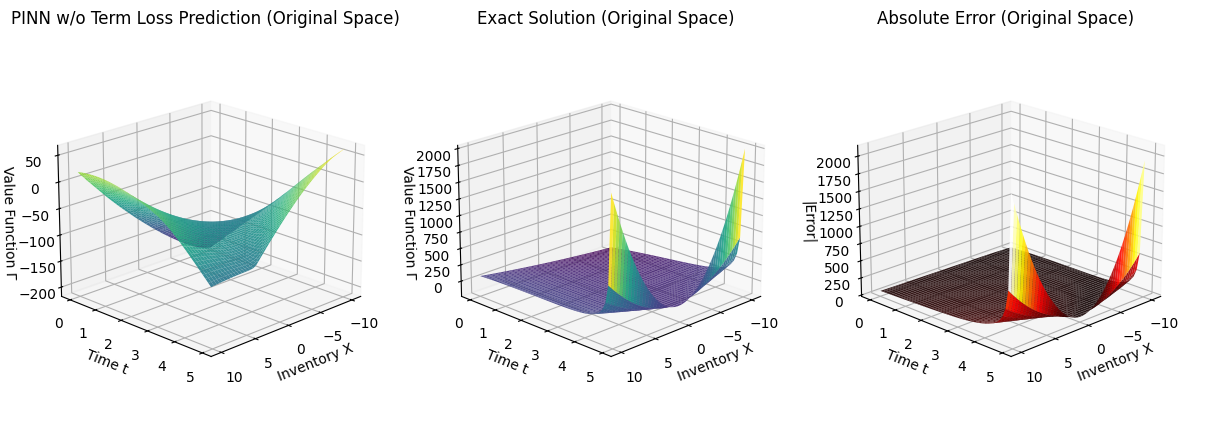

Original Space Error Statistics:
  Mean Absolute Error: 89.276477
  Max Absolute Error: 2107.500586
  Mean Relative Error: 16.482309
  Max Relative Error: 9439.440317
  L2 norm (RMSE): 165.033688


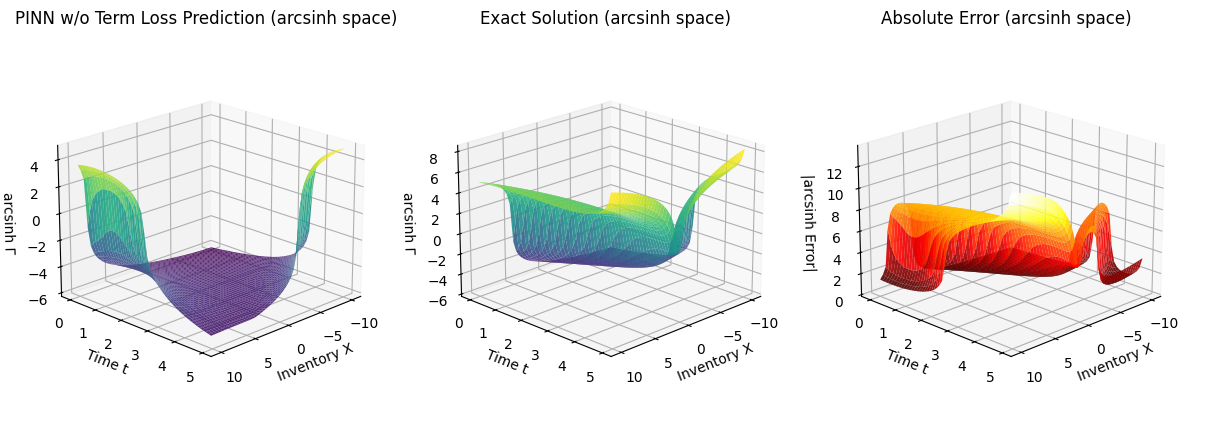

Arcsinh-Space Error Statistics:
  Mean Arcsinh Absolute Error: 4.508974
  Max Arcsinh Absolute Error: 13.652382
  Mean Arcsinh Relative Error: 2.193972
  Max Arcsinh Relative Error: 811.614670
  L2 norm (RMSE, arcsinh): 5.831732


In [34]:
plot_pinn_vs_exact(
        model_PINN, T=T, X0=10, x_range=(-10, 10),
        lam=0.1, kappa=0.1, sigma=0.1, S=55, d3=True, label='PINN w/o Term Loss'
    )

In [28]:
def inventory_trajectory_multi(models, paths, dt, T=1.0, X0=10, lam=0.01, kappa=0.05, d3=True):
    """Generate and plot inventory trajectories of multiple models against exact

    Args:
        models (dict): dictionary of all models to compare
        paths (np.ndarray): stock price paths
        dt (float): time step
        T (float): time horizon
        X0 (float): initial inventory
        lam (float): risk-aversion
        kappa (float): inventory-hold weighting
        d3 (bool): if lambda > 0. Defaults to True
    """
    # compute exact trajectories
    x_true = compute_x_star(paths, T=T, X=X0, lam=lam, kappa=kappa, dt=dt)
    n_paths, n_true = x_true.shape
    t_true = np.linspace(0, T, n_true)

    # colors per path (consistent across columns)
    path_colors = sns.color_palette("husl", n_paths)

    # evaluate each model and align to truth grid
    def _interp_to_grid(arr, t_src, t_tgt):
        out = np.full((arr.shape[0], t_tgt.size), np.nan, dtype=float)
        for i in range(arr.shape[0]):
            y = arr[i].astype(float)
            m = np.isfinite(y)
            if m.sum() >= 2:
                out[i] = np.interp(t_tgt, t_src[m], y[m])
        return out

    results = {}
    global_ymin, global_ymax = np.inf, -np.inf
    global_bar_min, global_bar_max = np.inf, -np.inf

    # stash aligned trajectories + finals
    aligned = {}   # name -> (x_pred_aligned, x_final_pred)
    for name, model in models.items():
        x_pred, _, _ = compute_pinn_trajectories(model, paths, T=T, X0=X0, dt=dt, d3=d3)
        t_pred = np.linspace(0, T, x_pred.shape[1])
        x_al = _interp_to_grid(x_pred, t_pred, t_true)
        aligned[name] = (x_al, x_al[:, -1])

        # update global limits (top row)
        global_ymin = min(global_ymin, np.nanmin(x_true), np.nanmin(x_al))
        global_ymax = max(global_ymax, np.nanmax(x_true), np.nanmax(x_al))
        # bottom row (finals)
        global_bar_min = min(global_bar_min, np.nanmin(x_true[:, -1]), np.nanmin(x_al[:, -1]))
        global_bar_max = max(global_bar_max, np.nanmax(x_true[:, -1]), np.nanmax(x_al[:, -1]))

        # metrics
        mask = np.isfinite(x_true) & np.isfinite(x_al)
        rmse = np.sqrt(np.nanmean((x_al[mask] - x_true[mask])**2))
        results[name] = {
            "rmse": float(rmse),
            "final_mean": float(np.nanmean(x_al[:, -1])),
            "final_std":  float(np.nanstd(x_al[:, -1])),
            "final_max_abs": float(np.nanmax(np.abs(x_al[:, -1]))),
        }

    # add a small margin to shared y-lims
    def _pad(a, b, frac=0.05):
        span = max(b - a, 1e-9)
        return a - frac*span, b + frac*span

    ylo, yhi = _pad(global_ymin, global_ymax, 0.06)
    blo, bhi = _pad(global_bar_min, global_bar_max, 0.15)

    # figure: 2 rows × N models columns
    names = list(models.keys())
    n = len(names)
    fig, axes = plt.subplots(2, n, figsize=(6.0*n, 6.8), constrained_layout=True)
    if n == 1:
        axes = np.array(axes).reshape(2, 1)

    for col, name in enumerate(names):
        ax_top = axes[0, col]
        ax_bot = axes[1, col]
        x_al, x_final = aligned[name]

        # top: trajectories per path (solid) + truth (dashed)
        for i in range(n_paths):
            ax_top.plot(t_true, x_al[i], color=path_colors[i], lw=2, alpha=0.95)
            ax_top.plot(t_true, x_true[i], color=path_colors[i], lw=2, ls="--", alpha=0.9)
        ax_top.set_ylim(ylo, yhi)
        ax_top.set_xlabel("Time")
        if col == 0:
            ax_top.set_ylabel("Inventory")
        ax_top.set_title(f"{name}: trajectories")
        ax_top.grid(True, ls=":", alpha=0.5)

        if col == 0:
            proxy_pred = plt.Line2D([0],[0], color="k", lw=2, label="Model")
            proxy_true = plt.Line2D([0],[0], color="k", lw=2, ls="--", label="True")
            ax_top.legend(handles=[proxy_pred, proxy_true], loc="best")

        # bottom: final inventories, grouped (model vs true) per path
        idx = np.arange(n_paths)
        width = 0.38
        ax_bot.bar(idx - width/2, x_true[:, -1], width, label="True",
                   alpha=0.6, color="lightgray", edgecolor="dimgray")
        ax_bot.bar(idx + width/2, x_final, width, label=name,
                   alpha=0.9, color=[path_colors[i] for i in idx], edgecolor="black", linewidth=0.6)

        # annotate model bars
        for j, val in enumerate(x_final):
            ax_bot.text(j + width/2, val, f"{val:.3f}", ha="center",
                        va="bottom" if val >= 0 else "top", fontsize=8)

        ax_bot.axhline(0, color="red", ls="--", lw=1.2, alpha=0.9)
        ax_bot.set_ylim(blo, bhi)
        ax_bot.set_xlabel("Path")
        if col == 0:
            ax_bot.set_ylabel("Final inventory")
        ax_bot.set_xticks(idx)
        ax_bot.set_xticklabels([f"P{i+1}" for i in idx])
        ax_bot.grid(True, axis="y", ls="--", alpha=0.35)
        ax_bot.set_axisbelow(True)

        # background
        for ax in (ax_top, ax_bot):
            ax.set_facecolor("#f9f9f9")


    fig.suptitle(r"Inventory trajectories $x^*(t)$ and final inventories", y=1.05, fontsize=13)
    fig.patch.set_facecolor("white")
    plt.show()

    # print summary
    print("=== Inventory comparison ===")
    for name in names:
        r = results[name]
        print(f"{name:>18} | RMSE={r['rmse']:.6f}  "
              f"final mean={r['final_mean']:.6f}  std={r['final_std']:.6f}  "
              f"max|final|={r['final_max_abs']:.6f}")



In [35]:
paths, dt = simulate_S(S0=55, sigma=0.1, T=5, Ndt=200, Npaths=3, seed=42)

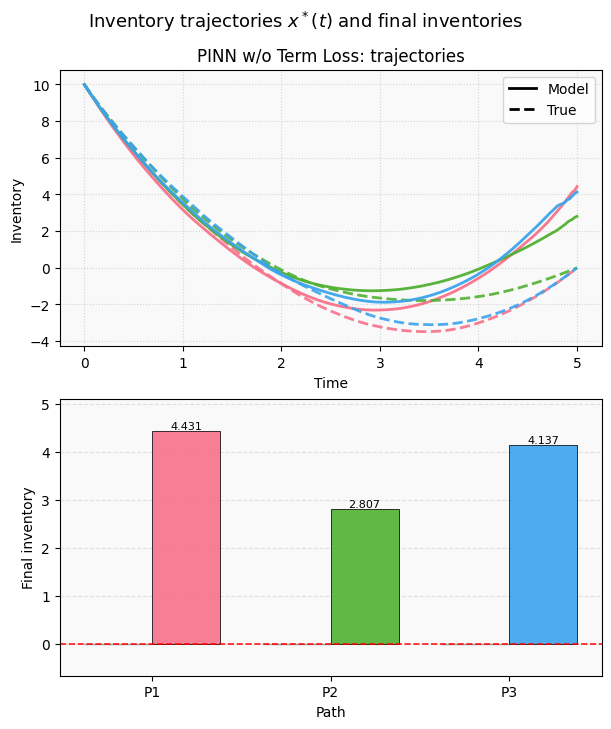

=== Inventory comparison ===
PINN w/o Term Loss | RMSE=1.554202  final mean=3.791719  std=0.706727  max|final|=4.431353


In [36]:
inventory_trajectory_multi({"PINN w/o Term Loss": model_PINN}, paths, dt, T=T, X0=10, lam=0.1, kappa=0.1, d3=True)